In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm  
from helpers import load_dataset_paths, load_vep_csv, compute_class_average_signal, summarize_results_and_save
import pywt
from featex import FeatureExtractor
from CNN_classifier import CNN1D
import shap

## 0. Loading Preprocessed Files and Metadata

In [ ]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")


# exclude SNR_summary_BC_and_RGC.csv from the list
prima_files_BC_and_RGC = [f for f in prima_files_BC_and_RGC if not f.endswith("SNR_summary_BC_and_RGC.csv")]
prima_files_RGC_only = [f for f in prima_files_RGC_only if not f.endswith("SNR_summary_RGC_Only.csv")]
prima_files_BC_only = [f for f in prima_files_BC_only if not f.endswith("SNR_summary_BC_Only.csv")]

PRIMA BC_Only files: 138
PRIMA RGC_Only files: 67
PRIMA BC_and_RGC files: 32


In [ ]:
# from scipy.stats import pearsonr

# # --- Load the per-category summary tables ---
# snr_summary_BC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_Only/SNR_summary_BC_Only.csv")
# snr_summary_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/RGC_Only/SNR_summary_RGC_Only.csv")
# snr_summary_BC_and_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_and_RGC/SNR_summary_BC_and_RGC.csv")

# # --- Compute SNR ratio ---
# for df in [snr_summary_BC, snr_summary_RGC, snr_summary_BC_and_RGC]:
#     df["SNR_Ratio"] = df["SNR_Signal"] / df["SNR_Noise"]
#     df["FileName"] = df["FileName"].str.strip()

# # --- IQR-based outlier removal ---
# def filter_by_iqr(df, label):
#     q1, q3 = df["SNR_Ratio"].quantile([0.25, 0.75])
#     iqr = q3 - q1
#     lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
#     filtered = df[(df["SNR_Ratio"] >= lower) & (df["SNR_Ratio"] <= upper)].copy()

#     n_removed = len(df) - len(filtered)
#     mean_ratio, std_ratio = filtered["SNR_Ratio"].mean(), filtered["SNR_Ratio"].std()
#     print(f"[{label}] kept {len(filtered):3d}/{len(df):3d} files  "
#           f"({len(filtered)/len(df)*100:5.1f}% kept, {n_removed} removed)  "
#           f"→ mean SNR ratio = {mean_ratio:6.2f} ± {std_ratio:6.2f}")
#     return filtered

# filtered_BC = filter_by_iqr(snr_summary_BC, "BC_Only")
# filtered_RGC = filter_by_iqr(snr_summary_RGC, "RGC_Only")
# filtered_BC_and_RGC = filter_by_iqr(snr_summary_BC_and_RGC, "BC_and_RGC")

# # --- Match filenames back to actual file paths ---
# def match_filtered_files(file_list, filtered_df, label):
#     def normalize_name(name):
#         base = os.path.basename(str(name)).strip().lower()
#         if not base.endswith(".csv"):
#             base += ".csv"
#         return base

#     filtered_names = [normalize_name(n) for n in filtered_df["FileName"]]
#     file_map = {normalize_name(f): f for f in file_list}
#     matched = [file_map[n] for n in filtered_names if n in file_map]
#     skipped = [n for n in filtered_names if n not in file_map]
#     print(f"[{label}] matched {len(matched)}/{len(filtered_names)} files ({len(skipped)} skipped)")
#     if skipped:
#         print("Skipped (not matched):", ", ".join(skipped[:8]), "..." if len(skipped) > 8 else "")
#     return matched

# prima_files_BC_only = match_filtered_files(prima_files_BC_only, filtered_BC, "BC_Only")
# prima_files_RGC_only = match_filtered_files(prima_files_RGC_only, filtered_RGC, "RGC_Only")
# prima_files_BC_and_RGC = match_filtered_files(prima_files_BC_and_RGC, filtered_BC_and_RGC, "BC_and_RGC")


# # --- Template correlation filter ---
# def template_correlation_filter(file_list, label, corr_thresh=0.3, t_min=10, t_max=200):
#     """
#     Keep only signals whose waveform correlates positively with the class average template.
#     """
#     if len(file_list) == 0:
#         print(f"[{label}] no files to process.")
#         return []

#     # Load all signals
#     all_signals = []
#     for f in file_list:
#         try:
#             _, sig = load_vep_csv(f, t_min=t_min, t_max=t_max, normalize=True)
#             all_signals.append(sig)
#         except Exception as e:
#             print(f"Skipped {f}: {e}")

#     if len(all_signals) == 0:
#         print(f"[{label}] no valid signals loaded.")
#         return []

#     # Align lengths
#     min_len = min(len(s) for s in all_signals)
#     signals = np.array([s[:min_len] for s in all_signals])
#     template = np.mean(signals, axis=0)

#     # Compute correlation for each signal
#     corrs = [pearsonr(sig, template)[0] for sig in signals]
#     keep_mask = np.array(corrs) >= corr_thresh

#     kept = np.array(file_list)[keep_mask].tolist()
#     removed = np.array(file_list)[~keep_mask].tolist()
#     print(f"[{label}] kept {len(kept):3d}/{len(file_list):3d} after template correlation filter "
#           f"(corr ≥ {corr_thresh})")

#     return kept

# # --- Apply template correlation filtering ---
# prima_files_BC_only = template_correlation_filter(prima_files_BC_only, "BC_Only")
# prima_files_RGC_only = template_correlation_filter(prima_files_RGC_only, "RGC_Only")
# prima_files_BC_and_RGC = template_correlation_filter(prima_files_BC_and_RGC, "BC_and_RGC")

# print("\nAfter IQR + correlation filtering:")
# print(f"  BC_Only:     {len(prima_files_BC_only)} files")
# print(f"  RGC_Only:    {len(prima_files_RGC_only)} files")
# print(f"  BC_and_RGC:  {len(prima_files_BC_and_RGC)} files")

# print(type(prima_files_BC_only))
# print(prima_files_RGC_only[:3])

[BC_Only] kept 125/137 files  ( 91.2% kept, 12 removed)  → mean SNR ratio =   2.05 ±   1.01
[RGC_Only] kept  60/ 66 files  ( 90.9% kept, 6 removed)  → mean SNR ratio =   1.62 ±   0.93
[BC_and_RGC] kept  29/ 31 files  ( 93.5% kept, 2 removed)  → mean SNR ratio =   5.28 ±   2.72
[BC_Only] matched 125/125 files (0 skipped)
[RGC_Only] matched 60/60 files (0 skipped)
[BC_and_RGC] matched 29/29 files (0 skipped)
[BC_Only] kept 101/125 after template correlation filter (corr ≥ 0.3)
[RGC_Only] kept  42/ 60 after template correlation filter (corr ≥ 0.3)
[BC_and_RGC] kept  29/ 29 after template correlation filter (corr ≥ 0.3)

After IQR + correlation filtering:
  BC_Only:     101 files
  RGC_Only:    42 files
  BC_and_RGC:  29 files
<class 'list'>
['Preprocessed_VEP_Data/PRIMA/RGC_Only/PRIMA100_13_0_5ms_6.09mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/RGC_Only/PRIMA100_13_1ms_4.80mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/RGC_Only/PRIMA100_13_1ms_7.22mWmm2.csv']


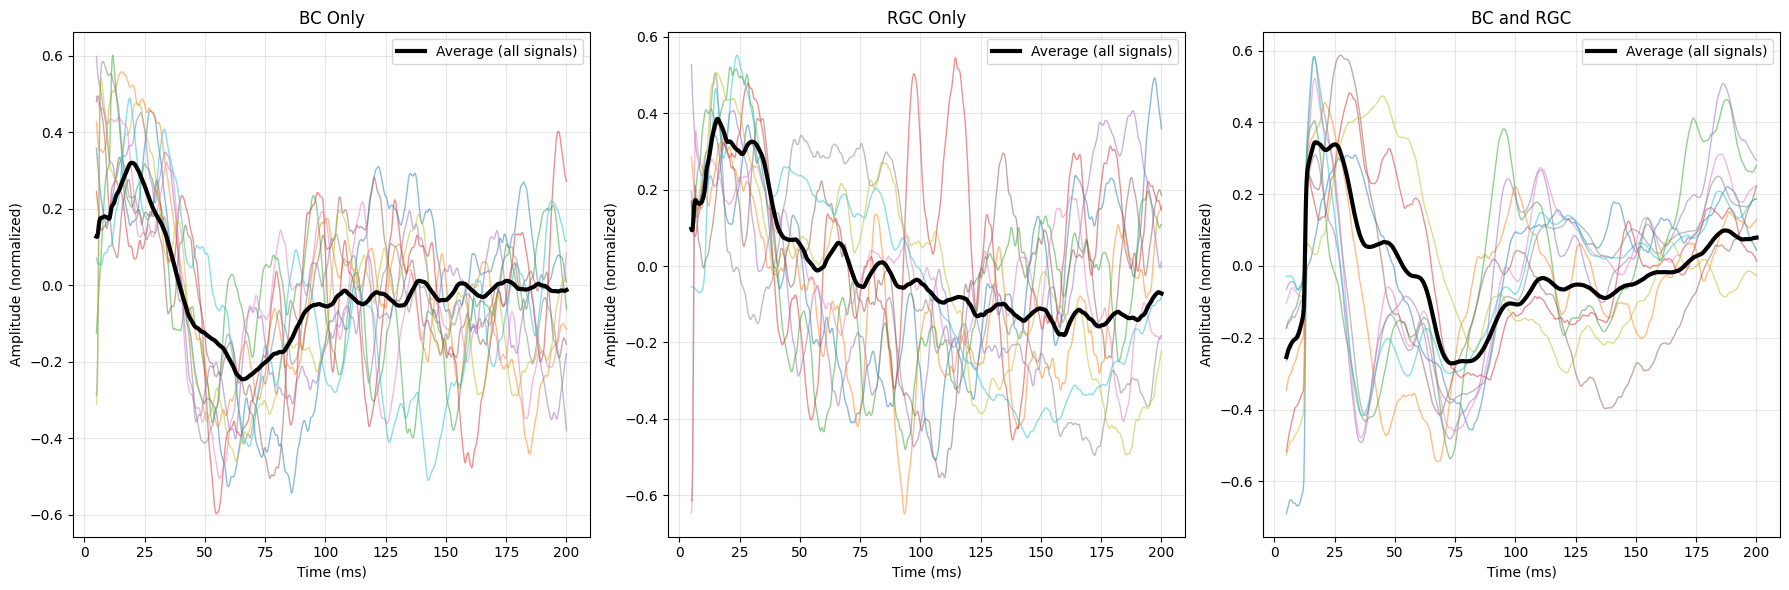

In [18]:
avg_BC_t, avg_BC_sig = compute_class_average_signal(prima_files_BC_only, t_min=5, t_max=200)
avg_RGC_t, avg_RGC_sig = compute_class_average_signal(prima_files_RGC_only, t_min=5, t_max=200)
avg_BC_RGC_t, avg_BC_RGC_sig = compute_class_average_signal(prima_files_BC_and_RGC, t_min=5, t_max=200)


# --- Choose 3 example files per category ---
example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(18, 6))

for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = load_vep_csv(file, t_min=5, t_max=200)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label="Average (all signals)")

    plt.title(title)
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. DWT feature extraction

In [19]:
dwt_features, labels = [], []
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    files = prima_files_BC_only if label == "BC_Only" else \
            prima_files_RGC_only if label == "RGC_Only" else \
            prima_files_BC_and_RGC

    for file in tqdm(files, desc=f"Extracting {label}"):
        _, signal = load_vep_csv(file, t_min=10, t_max=200)
        X_dwt = FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4, max_length=100)
        dwt_features.append(X_dwt) 
        labels.append(label)

# Pad all to equal length (for CNN or ML)
max_len = max(len(f) for f in dwt_features)
dwt_features_padded = np.array([np.pad(f, (0, max_len - len(f))) for f in dwt_features])
labels = np.array(labels)


Extracting BC_and_RGC: 100%|██████████| 29/29 [00:00<00:00, 828.69it/s]


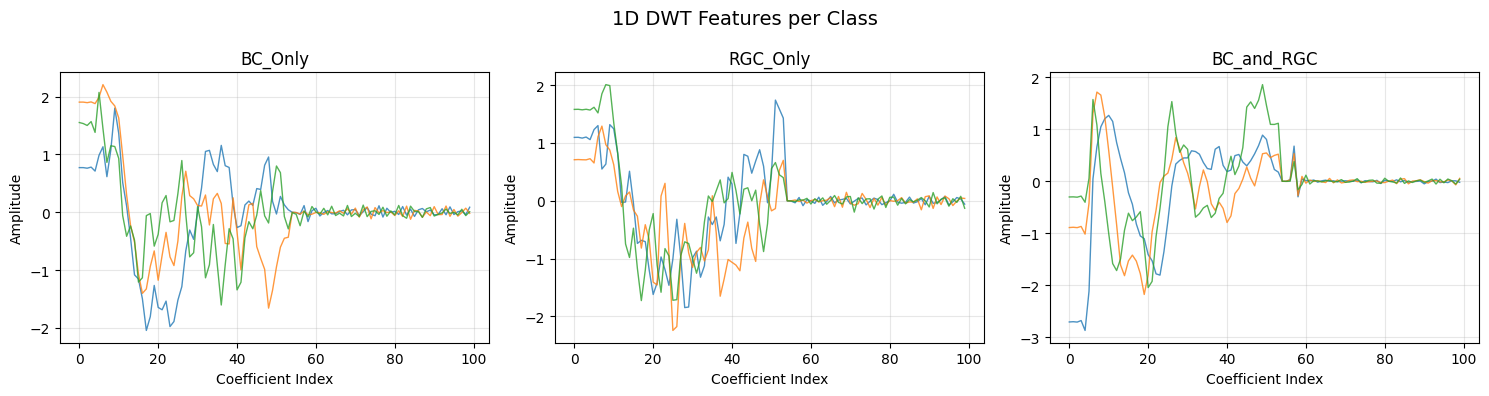

In [20]:
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

# --- Plot 1D DWT features per class ---
plt.figure(figsize=(15, 4))
for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Get up to 3 examples from this class
    class_indices = np.where(labels == label)[0][:3]
    
    for idx in class_indices:
        plt.plot(dwt_features_padded[idx], lw=1, alpha=0.8)
    
    plt.title(f"{label}")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)

plt.suptitle("1D DWT Features per Class", fontsize=14)
plt.tight_layout()
plt.show()

## Classification


=== Processing Signal Type: DWT ===
--- Experiment 1 ---
Number of training samples: 87
Using batch size: 8
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5942 |     0.5000
    2 |     0.9130 |     0.7778
    3 |     0.9565 |     0.8333
    4 |     0.9710 |     0.7778
    5 |     0.9710 |     0.8333
    6 |     0.9855 |     0.8889
    7 |     0.9710 |     0.8889
    8 |     1.0000 |     0.7778
    9 |     0.9855 |     0.7778
   10 |     1.0000 |     0.7778
   11 |     1.0000 |     0.7778
   12 |     1.0000 |     0.7222
   13 |     1.0000 |     0.7222
   14 |     1.0000 |     0.7222
   15 |     0.9855 |     0.7222
   16 |     1.0000 |     0.7222
   17 |     1.0000 |     0.7222
   18 |     1.0000 |     0.7222
   19 |     1.0000 |     0.7222
   20 |     1.0000 |     0.7222
   21 |     1.0000 |     0.7222
   22 |     1.0000 |     0.7222
   23 |     1.0000 |     0.7222
   24 |     1.0000 |     0.7222
   25 |     1.0000 |     0.8333
   26 |     1.0000 |     0.8333
   27 |     1.0000 |     0.8333
   28 |     1.0000 |     0.8333
   29 |     1.0000 |     0.8333
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_165
Received: inputs=['Tensor(shape=(69, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_165
Received: inputs=['Tensor(shape=(138, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5652 |     0.6111
    2 |     0.8696 |     0.5000
    3 |     0.9420 |     0.6667
    4 |     0.9565 |     0.7778
    5 |     0.9710 |     0.8333
    6 |     1.0000 |     0.8333
    7 |     1.0000 |     0.8333
    8 |     1.0000 |     0.8333
    9 |     0.9855 |     0.8333
   10 |     1.0000 |     0.8333
   11 |     0.9855 |     0.8333
   12 |     1.0000 |     0.7778
   13 |     1.0000 |     0.7778
   14 |     1.0000 |     0.7778
   15 |     0.9855 |     0.7778
   16 |     1.0000 |     0.7778
   17 |     1.0000 |     0.7778
   18 |     1.0000 |     0.7778
   19 |     1.0000 |     0.7778
   20 |     1.0000 |     0.7778
   21 |     1.0000 |     0.7778
   22 |     1.0000 |     0.7778
   23 |     1.0000 |     0.8333
   24 |     1.0000 |     0.8333
   25 |     1.0000 |     0.8333
   26 |     1.0000 |     0.8333
   27 |     1.0000 |     0.8333
   28 |     1.0000 |     0.8333
   29 |     1.0000 |     0.8889
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_176
Received: inputs=['Tensor(shape=(69, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_176
Received: inputs=['Tensor(shape=(138, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4714 |     0.7059
    2 |     0.8857 |     0.8824
    3 |     0.9714 |     0.8824
    4 |     0.9857 |     0.8824
    5 |     0.9714 |     0.8824
    6 |     0.9857 |     0.8824
    7 |     1.0000 |     0.8235
    8 |     1.0000 |     0.7647
    9 |     1.0000 |     0.7647
   10 |     1.0000 |     0.7647
   11 |     1.0000 |     0.7059
   12 |     1.0000 |     0.7059
   13 |     1.0000 |     0.7059
   14 |     1.0000 |     0.7059
   15 |     1.0000 |     0.6471
   16 |     1.0000 |     0.7059
   17 |     1.0000 |     0.7647
   18 |     0.9857 |     0.7647
   19 |     1.0000 |     0.8235
   20 |     1.0000 |     0.8235
   21 |     1.0000 |     0.8235
   22 |     1.0000 |     0.8235
   23 |     1.0000 |     0.8235
   24 |     1.0000 |     0.8824
   25 |     1.0000 |     0.8824
   26 |     1.0000 |     0.9412
   27 |     1.0000 |     0.9412
   28 |     1.0000 |     0.9412
   29 |     1.0000 |     0.9412
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_187
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_187
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4571 |     0.4118
    2 |     0.8857 |     0.5882
    3 |     0.9571 |     0.5882
    4 |     0.9714 |     0.6471
    5 |     1.0000 |     0.7059
    6 |     1.0000 |     0.7647
    7 |     1.0000 |     0.7647
    8 |     1.0000 |     0.7059
    9 |     1.0000 |     0.7647
   10 |     1.0000 |     0.7647
   11 |     1.0000 |     0.7647
   12 |     1.0000 |     0.7647
   13 |     0.9857 |     0.7647
   14 |     1.0000 |     0.7647
   15 |     1.0000 |     0.7647
   16 |     1.0000 |     0.7647
   17 |     1.0000 |     0.7647
   18 |     1.0000 |     0.7647
   19 |     1.0000 |     0.7647
   20 |     1.0000 |     0.7647
   21 |     1.0000 |     0.7647
   22 |     1.0000 |     0.8235
   23 |     1.0000 |     0.8235
   24 |     1.0000 |     0.8824
   25 |     1.0000 |     0.8824
   26 |     1.0000 |     0.8824
   27 |     1.0000 |     0.8824
   28 |     1.0000 |     0.8824
   29 |     1.0000 |     0.8824
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_198
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_198
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.3714 |     0.5294
    2 |     0.8286 |     0.7647
    3 |     0.9429 |     0.8235
    4 |     0.9857 |     0.8235
    5 |     0.9286 |     0.8235
    6 |     0.9714 |     0.8235
    7 |     0.9857 |     0.8235
    8 |     1.0000 |     0.8235
    9 |     1.0000 |     0.6471
   10 |     0.9857 |     0.6471
   11 |     1.0000 |     0.6471
   12 |     1.0000 |     0.5882
   13 |     1.0000 |     0.5882
   14 |     1.0000 |     0.5882
   15 |     1.0000 |     0.5882
   16 |     1.0000 |     0.5882
   17 |     1.0000 |     0.6471
   18 |     1.0000 |     0.6471
   19 |     1.0000 |     0.7059
   20 |     1.0000 |     0.7647
   21 |     1.0000 |     0.7647
   22 |     1.0000 |     0.7647
   23 |     1.0000 |     0.7647
   24 |     1.0000 |     0.7059
   25 |     1.0000 |     0.7059
   26 |     1.0000 |     0.7059
   27 |     0.9857 |     0.7647
   28 |     1.0000 |     0.7647
   29 |     1.0000 |     0.8235
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_209
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_209
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)


shap_results_shapes: (17, 100, 1, 3)
mean_shap shape: (100,)
mean_shap shape: (100,)
mean_shap shape: (100,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_209
Received: inputs=['Tensor(shape=(17, 100, 1))']
  warnings.warn(msg)


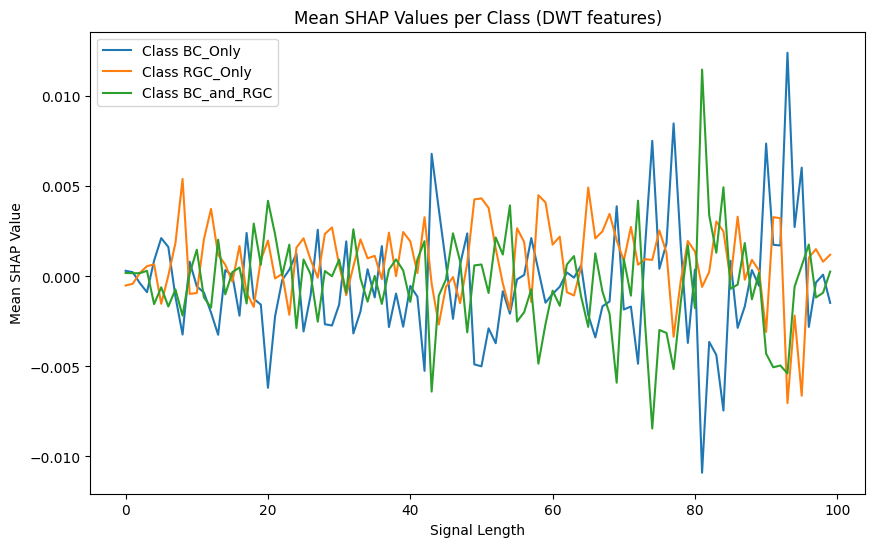

[[26  2  1]
 [ 7 22  0]
 [ 1  0 28]]
--- Experiment 2 ---
Number of training samples: 87
Using batch size: 8
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5797 |     0.6667
    2 |     0.9130 |     0.7222
    3 |     0.9565 |     0.7222
    4 |     0.9855 |     0.8333
    5 |     0.9855 |     0.8333
    6 |     1.0000 |     0.7778
    7 |     1.0000 |     0.7778
    8 |     1.0000 |     0.7778
    9 |     1.0000 |     0.7778
   10 |     1.0000 |     0.7778
   11 |     1.0000 |     0.7778
   12 |     1.0000 |     0.8333
   13 |     1.0000 |     0.8333
   14 |     1.0000 |     0.7778
   15 |     1.0000 |     0.7778
   16 |     1.0000 |     0.7778
   17 |     1.0000 |     0.7778
   18 |     1.0000 |     0.7778
   19 |     1.0000 |     0.7778
   20 |     1.0000 |     0.8333
   21 |     1.0000 |     0.8333
   22 |     1.0000 |     0.8333
   23 |     1.0000 |     0.8333
   24 |     1.0000 |     0.8333
   25 |     1.0000 |     0.7778
   26 |     1.0000 |     0.7778
   27 |     1.0000 |     0.7778
   28 |     1.0000 |     0.7778
   29 |     1.0000 |     0.7778
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_220
Received: inputs=['Tensor(shape=(69, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_220
Received: inputs=['Tensor(shape=(138, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5362 |     0.4444
    2 |     0.8551 |     0.7222
    3 |     0.9130 |     0.8333
    4 |     0.9710 |     0.8333
    5 |     0.9855 |     0.8889
    6 |     1.0000 |     0.8889
    7 |     1.0000 |     0.8889
    8 |     1.0000 |     0.8889
    9 |     1.0000 |     0.8889
   10 |     1.0000 |     0.8889
   11 |     1.0000 |     0.8889
   12 |     1.0000 |     0.8333
   13 |     1.0000 |     0.8333
   14 |     1.0000 |     0.8333
   15 |     1.0000 |     0.8333
   16 |     1.0000 |     0.8333
   17 |     0.9855 |     0.8333
   18 |     1.0000 |     0.8333
   19 |     0.9855 |     0.8333
   20 |     1.0000 |     0.8889
   21 |     1.0000 |     0.8889
   22 |     1.0000 |     0.8889
   23 |     1.0000 |     0.8889
   24 |     1.0000 |     0.8889
   25 |     1.0000 |     0.8889
   26 |     1.0000 |     0.8889
   27 |     1.0000 |     0.8889
   28 |     1.0000 |     0.8889
   29 |     1.0000 |     0.8889
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_231
Received: inputs=['Tensor(shape=(69, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_231
Received: inputs=['Tensor(shape=(138, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.6000 |     0.6471
    2 |     0.8714 |     0.5882
    3 |     0.9571 |     0.7647
    4 |     0.9857 |     0.7647
    5 |     0.9714 |     0.7647
    6 |     0.9857 |     0.7647
    7 |     0.9857 |     0.7647
    8 |     1.0000 |     0.6471
    9 |     1.0000 |     0.6471
   10 |     1.0000 |     0.6471
   11 |     1.0000 |     0.6471
   12 |     1.0000 |     0.6471
   13 |     1.0000 |     0.6471
   14 |     1.0000 |     0.7059
   15 |     1.0000 |     0.7059
   16 |     1.0000 |     0.7059
   17 |     1.0000 |     0.7059
   18 |     1.0000 |     0.7059
   19 |     1.0000 |     0.7059
   20 |     1.0000 |     0.7059
   21 |     1.0000 |     0.7059
   22 |     1.0000 |     0.7059
   23 |     1.0000 |     0.7059
   24 |     1.0000 |     0.7059
   25 |     1.0000 |     0.7059
   26 |     1.0000 |     0.7059
   27 |     1.0000 |     0.7059
   28 |     1.0000 |     0.7059
   29 |     1.0000 |     0.7059
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_242
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_242
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5286 |     0.4118
    2 |     0.8857 |     0.5882
    3 |     0.9857 |     0.6471
    4 |     0.9571 |     0.6471
    5 |     0.9857 |     0.7647
    6 |     0.9857 |     0.8235
    7 |     1.0000 |     0.8235
    8 |     1.0000 |     0.7647
    9 |     1.0000 |     0.7647
   10 |     1.0000 |     0.7059
   11 |     1.0000 |     0.7059
   12 |     1.0000 |     0.7059
   13 |     1.0000 |     0.7059
   14 |     1.0000 |     0.7059
   15 |     1.0000 |     0.7059
   16 |     1.0000 |     0.7059
   17 |     1.0000 |     0.7059
   18 |     1.0000 |     0.7059
   19 |     1.0000 |     0.7059
   20 |     1.0000 |     0.7059
   21 |     1.0000 |     0.7059
   22 |     1.0000 |     0.7059
   23 |     1.0000 |     0.7059
   24 |     1.0000 |     0.7059
   25 |     1.0000 |     0.7059
   26 |     1.0000 |     0.7059
   27 |     1.0000 |     0.7059
   28 |     1.0000 |     0.7059
   29 |     1.0000 |     0.7059
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_253
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_253
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5000 |     0.5294
    2 |     0.9000 |     0.8824
    3 |     0.9857 |     0.8235
    4 |     1.0000 |     0.7647
    5 |     0.9429 |     0.7647
    6 |     1.0000 |     0.8235
    7 |     0.9857 |     0.8235
    8 |     1.0000 |     0.8235
    9 |     0.9714 |     0.7647
   10 |     0.9857 |     0.7647
   11 |     1.0000 |     0.7647
   12 |     1.0000 |     0.7647
   13 |     1.0000 |     0.7647
   14 |     1.0000 |     0.7647
   15 |     1.0000 |     0.7647
   16 |     1.0000 |     0.7647
   17 |     1.0000 |     0.7647
   18 |     1.0000 |     0.7647
   19 |     1.0000 |     0.7647
   20 |     1.0000 |     0.7647
   21 |     1.0000 |     0.7647
   22 |     1.0000 |     0.7647
   23 |     1.0000 |     0.7647
   24 |     1.0000 |     0.7647
   25 |     1.0000 |     0.7647
   26 |     1.0000 |     0.7647
   27 |     1.0000 |     0.7647
   28 |     1.0000 |     0.7647
   29 |     1.0000 |     0.7647
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_264
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_264
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)


shap_results_shapes: (17, 100, 1, 3)
mean_shap shape: (100,)
mean_shap shape: (100,)
mean_shap shape: (100,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_264
Received: inputs=['Tensor(shape=(17, 100, 1))']
  warnings.warn(msg)


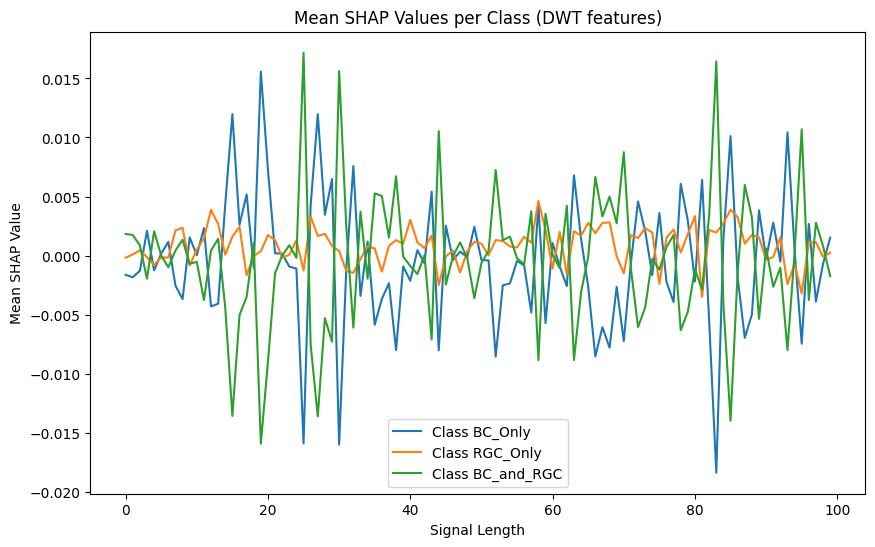

[[20  8  1]
 [ 6 23  0]
 [ 0  0 29]]
--- Experiment 3 ---
Number of training samples: 87
Using batch size: 8
Using epochs: 50


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5072 |     0.7778
    2 |     0.9420 |     0.7222
    3 |     0.9275 |     0.7778
    4 |     0.9565 |     0.9444
    5 |     1.0000 |     0.8889
    6 |     1.0000 |     0.7778
    7 |     1.0000 |     0.7778
    8 |     1.0000 |     0.7778
    9 |     1.0000 |     0.7778
   10 |     1.0000 |     0.7778
   11 |     1.0000 |     0.7778
   12 |     1.0000 |     0.7778
   13 |     0.9855 |     0.7778
   14 |     1.0000 |     0.7778
   15 |     1.0000 |     0.7778
   16 |     1.0000 |     0.7778
   17 |     1.0000 |     0.7778
   18 |     1.0000 |     0.7778
   19 |     1.0000 |     0.7778
   20 |     1.0000 |     0.7778
   21 |     1.0000 |     0.7778
   22 |     1.0000 |     0.7778
   23 |     1.0000 |     0.7778
   24 |     1.0000 |     0.7778
   25 |     1.0000 |     0.7778
   26 |     1.0000 |     0.7778
   27 |     1.0000 |     0.7778
   28 |     1.0000 |     0.7778
   29 |     1.0000 |     0.7778
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_275
Received: inputs=['Tensor(shape=(69, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_275
Received: inputs=['Tensor(shape=(138, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5217 |     0.3333
    2 |     0.8551 |     0.6111
    3 |     0.9275 |     0.8333
    4 |     0.9565 |     0.8333
    5 |     0.9855 |     0.8889
    6 |     1.0000 |     0.8333
    7 |     1.0000 |     0.8333
    8 |     0.9855 |     0.8889
    9 |     1.0000 |     0.8889
   10 |     1.0000 |     0.8889
   11 |     1.0000 |     0.8889
   12 |     1.0000 |     0.8889
   13 |     0.9855 |     0.8889
   14 |     1.0000 |     0.8889
   15 |     1.0000 |     0.8889
   16 |     1.0000 |     0.8889
   17 |     1.0000 |     0.8889
   18 |     1.0000 |     0.8889
   19 |     1.0000 |     0.8889
   20 |     1.0000 |     0.8889
   21 |     1.0000 |     0.8889
   22 |     1.0000 |     0.8889
   23 |     1.0000 |     0.8889
   24 |     1.0000 |     0.8889
   25 |     1.0000 |     0.8889
   26 |     1.0000 |     0.8889
   27 |     1.0000 |     0.8889
   28 |     1.0000 |     0.8889
   29 |     1.0000 |     0.8889
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_286
Received: inputs=['Tensor(shape=(69, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_286
Received: inputs=['Tensor(shape=(138, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5857 |     0.5882
    2 |     0.8571 |     0.7059
    3 |     0.9286 |     0.8235
    4 |     0.9286 |     0.9412
    5 |     0.9714 |     0.8824
    6 |     1.0000 |     0.8824
    7 |     0.9857 |     0.8235
    8 |     1.0000 |     0.8235
    9 |     1.0000 |     0.8824
   10 |     1.0000 |     1.0000
   11 |     1.0000 |     0.8824
   12 |     1.0000 |     0.8824
   13 |     1.0000 |     0.9412
   14 |     1.0000 |     0.9412
   15 |     1.0000 |     0.9412
   16 |     1.0000 |     0.9412
   17 |     1.0000 |     0.9412
   18 |     1.0000 |     0.9412
   19 |     0.9857 |     0.8824
   20 |     1.0000 |     0.8824
   21 |     1.0000 |     0.8824
   22 |     1.0000 |     0.8824
   23 |     1.0000 |     0.8824
   24 |     1.0000 |     0.9412
   25 |     1.0000 |     0.8824
   26 |     1.0000 |     0.8824
   27 |     1.0000 |     0.8824
   28 |     1.0000 |     0.8824
   29 |     1.0000 |     0.8824
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_297
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_297
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5429 |     0.3529
    2 |     0.8000 |     0.5294
    3 |     0.9429 |     0.5882
    4 |     1.0000 |     0.5882
    5 |     0.9714 |     0.7647
    6 |     0.9857 |     0.7647
    7 |     1.0000 |     0.7647
    8 |     0.9857 |     0.8235
    9 |     0.9857 |     0.8235
   10 |     1.0000 |     0.8235
   11 |     0.9857 |     0.7647
   12 |     1.0000 |     0.7647
   13 |     1.0000 |     0.7647
   14 |     1.0000 |     0.7647
   15 |     1.0000 |     0.7647
   16 |     1.0000 |     0.7647
   17 |     1.0000 |     0.7647
   18 |     1.0000 |     0.7647
   19 |     1.0000 |     0.7647
   20 |     1.0000 |     0.7647
   21 |     1.0000 |     0.7647
   22 |     1.0000 |     0.7647
   23 |     1.0000 |     0.7647
   24 |     1.0000 |     0.7647
   25 |     1.0000 |     0.8235
   26 |     1.0000 |     0.8235
   27 |     1.0000 |     0.8235
   28 |     1.0000 |     0.8235
   29 |     1.0000 |     0.8235
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_308
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_308
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4714 |     0.5882
    2 |     0.8571 |     0.8235
    3 |     0.9714 |     0.8824
    4 |     0.9714 |     0.7647
    5 |     0.9714 |     0.7647
    6 |     0.9857 |     0.7647
    7 |     1.0000 |     0.7647
    8 |     0.9714 |     0.7647
    9 |     1.0000 |     0.8235
   10 |     1.0000 |     0.8235
   11 |     1.0000 |     0.8235
   12 |     0.9857 |     0.7647
   13 |     1.0000 |     0.7647
   14 |     1.0000 |     0.7647
   15 |     1.0000 |     0.7647
   16 |     1.0000 |     0.7647
   17 |     1.0000 |     0.7647
   18 |     1.0000 |     0.7647
   19 |     1.0000 |     0.7647
   20 |     1.0000 |     0.7647
   21 |     1.0000 |     0.7647
   22 |     1.0000 |     0.7647
   23 |     1.0000 |     0.7647
   24 |     1.0000 |     0.7647
   25 |     1.0000 |     0.7647
   26 |     1.0000 |     0.7647
   27 |     1.0000 |     0.7647
   28 |     1.0000 |     0.7647
   29 |     1.0000 |     0.7647
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_319
Received: inputs=['Tensor(shape=(70, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_319
Received: inputs=['Tensor(shape=(140, 100, 1))']
  warnings.warn(msg)


shap_results_shapes: (17, 100, 1, 3)
mean_shap shape: (100,)
mean_shap shape: (100,)
mean_shap shape: (100,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_319
Received: inputs=['Tensor(shape=(17, 100, 1))']
  warnings.warn(msg)


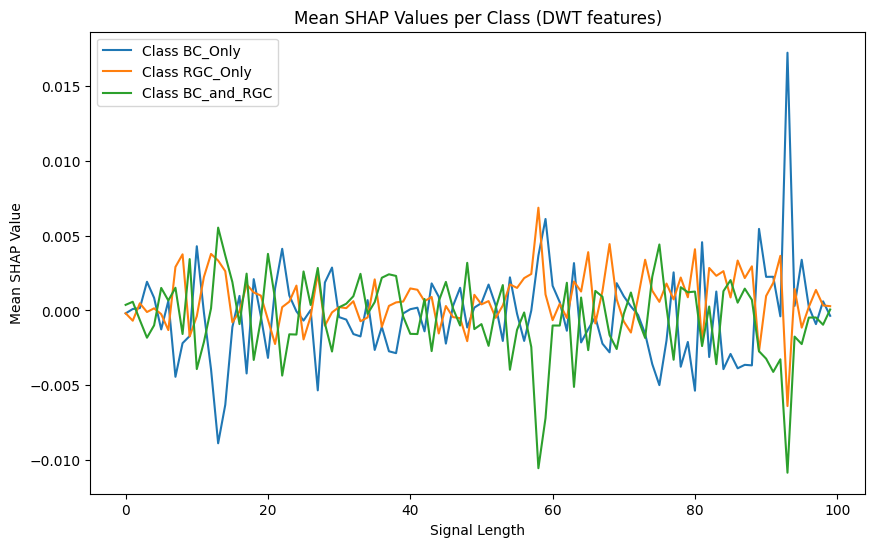

[[22  6  1]
 [ 5 24  0]
 [ 0  0 29]]


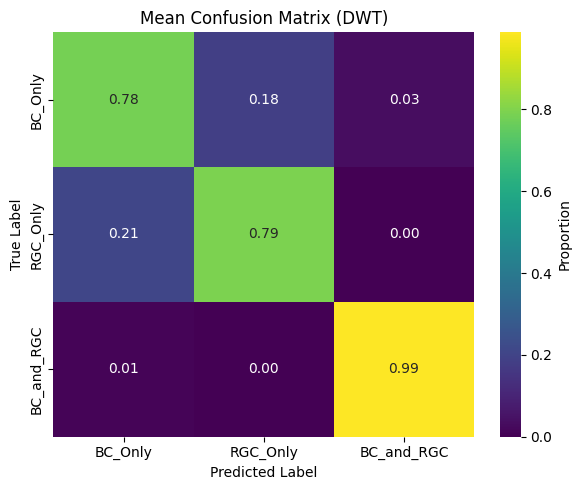

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

average_results = {}

signal_types = ["DWT"]

for signal_type in signal_types:
    print(f"\n=== Processing Signal Type: {signal_type} ===")
    results = []
    all_conf_matrices = []
    for experiments in range(3):
        print(f"--- Experiment {experiments + 1} ---")
        np.random.seed(42)
        no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
        sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
        sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
        sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

        X, labels = [], []
        for file in sampled_BC:
            _, signal = load_vep_csv(file, t_min=5, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("BC_Only")
        for file in sampled_RGC:
            _, signal = load_vep_csv(file, t_min=5, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("RGC_Only")
        for file in sampled_BC_and_RGC:
            _, signal = load_vep_csv(file, t_min=5, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("BC_and_RGC")

        n_train = len(X)
        print(f"Number of training samples: {n_train}")
        # batch_size = 4
        # epochs = 30
        batch_size = max(4, min(32, n_train // 10))

        print(f"Using batch size: {batch_size}")
        if n_train < 100:
            epochs = 50
        elif n_train < 500:
            epochs = 35
        else:
            epochs = 20
        print(f"Using epochs: {epochs}")

        clf = CNN1D(X, labels, model_type="cnn", n_splits=5, random_state=42)
        y_true, y_pred, shap_values = clf.fit(epochs=epochs, batch_size=batch_size)
        print("shap_results_shapes:", shap_values.shape) # (17, 761, 1, 3) = (n_samples, signal_length, 1, n_classes)
        plt.figure(figsize=(10, 6))
        for c in range(shap_values.shape[-1]):
            mean_shap = np.mean(shap_values[:, :, 0, c], axis=0)  # Mean SHAP values for class c
            print("mean_shap shape:", mean_shap.shape)  # (signal_length,)
            plt.plot(mean_shap, label=f"Class {unique_labels[c]}")
        plt.title(f"Mean SHAP Values per Class ({signal_type} features)")
        plt.xlabel("Signal Length")
        plt.ylabel("Mean SHAP Value")
        plt.legend()
        plt.show()
        metrics = clf.evaluate(y_true, y_pred)

        results.append({
                "Accuracy": metrics["accuracy"],
                "BalancedAcc": metrics["balanced_accuracy"],
                "F1": metrics["f1_score"],
                "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
                "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
                "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
            })
        all_conf_matrices.append(
            confusion_matrix(
                y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
            )
        )

    accs = [r["Accuracy"] for r in results]
    balanced_accs = [r["BalancedAcc"] for r in results]
    f1s = [r["F1"] for r in results]
    bc_accs = [float(r["Acc BC_Only"]) for r in results]
    rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
    bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

    average_results[(signal_type)] = {
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "BalancedAcc_mean": np.mean(balanced_accs),
        "BalancedAcc_std": np.std(balanced_accs),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),

        # per-class accuracies (recall)
        "Acc_BC_Only_mean": np.mean(bc_accs),
        "Acc_BC_Only_std": np.std(bc_accs),
        "Acc_RGC_Only_mean": np.mean(rgc_accs),
        "Acc_RGC_Only_std": np.std(rgc_accs),
        "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
        "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
    }
    mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
    mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

    labels = ["BC_Only", "RGC_Only", "BC_and_RGC"] 
    plt.figure(figsize=(6,5)) 
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'}) 
    plt.title(f"Mean Confusion Matrix ({signal_type})") 
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label") 
    plt.tight_layout()
    plt.show()

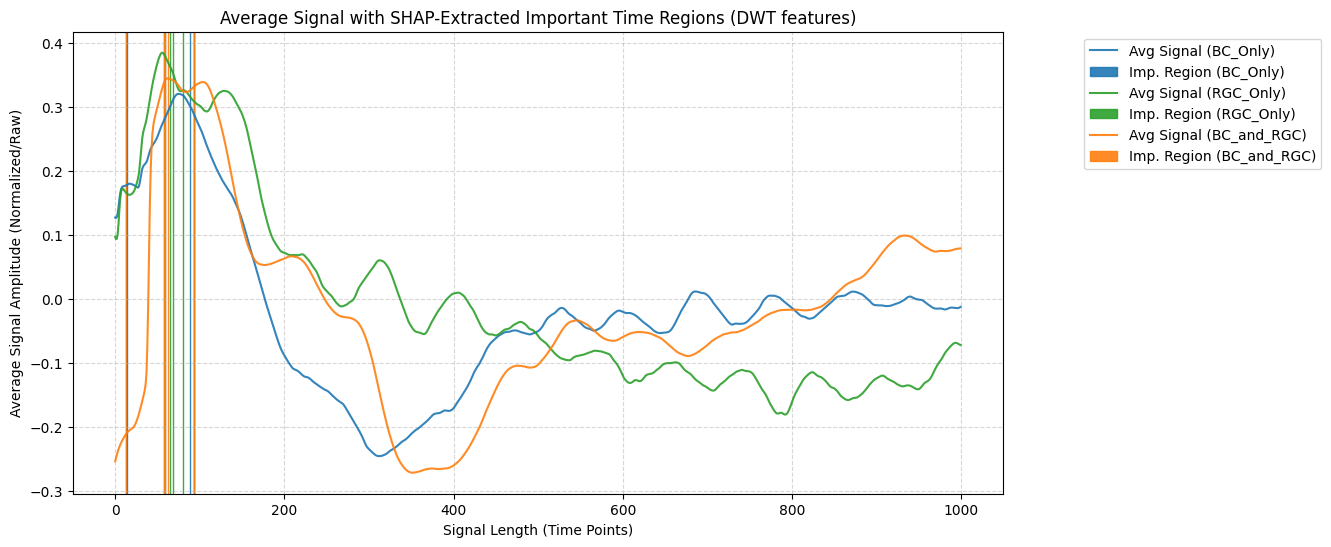

In [24]:
ABS_SHAP_THRESHOLD_PERCENTILE = 95
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
label_colors = ['tab:blue', 'tab:green', 'tab:orange']

# Calculate the overall average signal for each class for visualization
mean_signals = {}
# append avg_BC_sig, avg_RGC_sig, avg_BC_RGC_sig to mean_signals
mean_signals["BC_Only"] = avg_BC_sig
mean_signals["RGC_Only"] = avg_RGC_sig
mean_signals["BC_and_RGC"] = avg_BC_RGC_sig

# Create a new figure for the visualization
plt.figure(figsize=(12, 6))

for c in range(shap_values.shape[-1]):
    class_label = unique_labels[c] 
    mean_shap = np.mean(shap_values[:, :, 0, c], axis=0) 
    abs_mean_shap = np.abs(mean_shap)
    threshold = np.percentile(abs_mean_shap, ABS_SHAP_THRESHOLD_PERCENTILE) 
    important_indices = np.where(abs_mean_shap >= threshold)[0]
    
    plt.plot(mean_signals[class_label], 
             label=f"Avg Signal ({class_label})", 
             color=label_colors[c], 
             alpha=0.9)
    
    # Group continuous indices (simplified grouping for demonstration)
    segments = []
    if important_indices.size > 0:
        start = important_indices[0]
        end = important_indices[0]
        for i in range(1, len(important_indices)):
            if important_indices[i] == important_indices[i-1] + 1:
                end = important_indices[i]
            else:
                segments.append((start, end))
                start = important_indices[i]
                end = important_indices[i]
        segments.append((start, end))
        
    for start, end in segments:
        # Highlight the segment 
        plt.axvspan(start, end, 
                    alpha=0.9, 
                    color=label_colors[c], 
                    label=f"Imp. Region ({class_label})" if start == segments[0][0] else None)

# Add descriptive plot elements
plt.title(f"Average Signal with SHAP-Extracted Important Time Regions ({signal_type} features)")
plt.xlabel("Signal Length (Time Points)")
plt.ylabel("Average Signal Amplitude (Normalized/Raw)")
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [25]:
summarize_results_and_save(average_results, model_name="1DCNN")


Top 10 setups by F1 Score:
Model Feature_Type F1 (mean ± std) BC_Only (mean ± std) RGC_Only (mean ± std) BC_and_RGC (mean ± std)
1DCNN          DWT    0,853 ± 0,02        0,782 ± 0,086         0,793 ± 0,028           0,989 ± 0,016

Summary saved to: results/1DCNN_average_classification_results.csv
